In [25]:
from __future__ import annotations

import gymnasium as gym
import minigrid

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper


import matplotlib.pyplot as plt
import numpy as np
import math
import random

import matplotlib.animation as animation
from IPython.display import HTML

# Create the Grid-World envrionment

## Approach 1

In this approach, the module is used to initialise the envrionent directly, from scratch

In [2]:
env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")
observation, info = env.reset(seed=42)

manual_control = ManualControl(env, seed=42)

# Create a new grid
obs, info = env.reset()

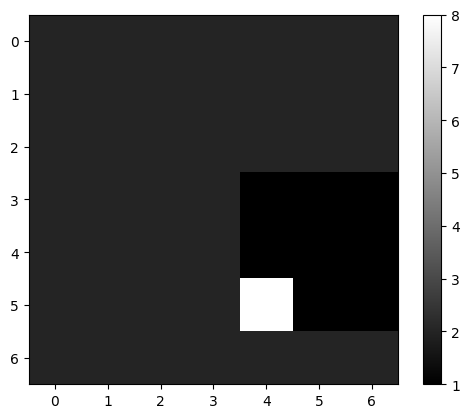

In [3]:
# This allows us to visualise the local grid
import matplotlib.pyplot as plt

plt.imshow(obs["image"][:, :, 0], cmap="gray")  # Show object types only
plt.colorbar()
plt.show()

(5, 5, 3)
[[ 2  2  2  2  2]
 [ 2 10  1  1  2]
 [ 2  1  1  1  2]
 [ 2  1  1  8  2]
 [ 2  2  2  2  2]]


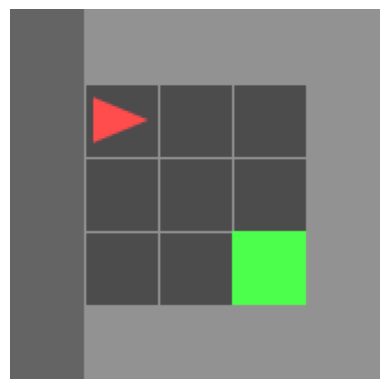

In [62]:
# Instead if we want a picture of the entire grid on which the agent is acting
# we can use the FullyObsWrapper

env = FullyObsWrapper(gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array"))
obs, info = env.reset()

print(obs['image'].shape)  # (5, 5, 3) - Full map
print(obs['image'][:, :, 0])  # (5, 5) - Object types

# However, using this mode the environment cannot be rendered because the 
# FullyObsWrapper modifies the observation space to provide the full grid observation
# and does not retain the rendering functionality of the original environment.

# To render the environment, you can use the base environment without the wrapper
base_env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")
obs, info = base_env.reset()
plt.imshow(base_env.render())
plt.axis("off")
plt.show()


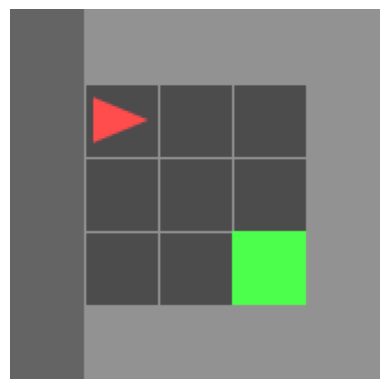

In [7]:
# Render and show the initial state
plt.imshow(env.render())
plt.axis("off")
plt.show()

## Approach 2

In this apporach, we build the envrionment from scratch is SimpleEnv inheriting from MiniGridEnv

In [20]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=8,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"
    
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

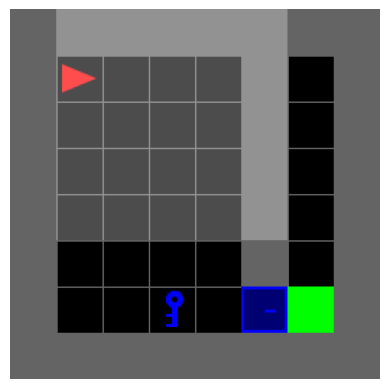

In [21]:
env = SimpleEnv(render_mode="rgb_array")

# enable manual control for testing
manual_control = ManualControl(env, seed=42)

env._gen_grid(8, 8)
env.reset()

# Render and show the initial state
plt.imshow(env.render())
plt.axis("off")
plt.show()

# Create an agent

### Random Agent

This code is to find the distribution of the reward when using a purely random policy. This is so that we can change the distribution of the rewards as required for the agent.

In [ ]:
rewards = []

for i in range(1000):
    done = False
    obs, info = env.reset()

    while not done:
        action = env.action_space.sample()  # Take a random action
        obs, reward, done, truncated, info = env.step(action)
        print(f"State: {obs['image'][:, :, 0]}, Action: {action}, Reward: {reward}, Done: {done}")
        
    rewards.append(reward)

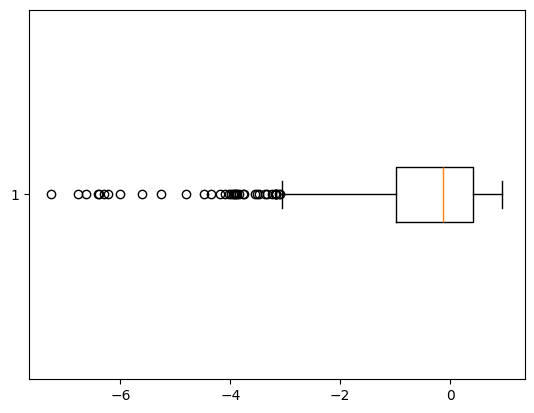

Mean reward: -0.47195000000000004
Standard deviation of reward: 1.2342575685406998
Q1 reward: -0.9800000000000002
Q2 reward: -0.12050000000000005
Q3 reward: 0.4262499999999999
Min reward: -7.2620000000000005


In [32]:
plt.boxplot(rewards, vert=False)
plt.show()

# Print the mean, standard deviation, quartiles and median of the rewards
mean_reward = np.mean(rewards)
std_reward = np.std(rewards)
q1_reward = np.percentile(rewards, 25)
q2_reward = np.median(rewards)
q3_reward = np.percentile(rewards, 75)
print(f"Mean reward: {mean_reward}")
print(f"Standard deviation of reward: {std_reward}")
print(f"Q1 reward: {q1_reward}")
print(f"Q2 reward: {q2_reward}")
print(f"Q3 reward: {q3_reward}")
print(f"Min reward: { np.min(rewards) }")

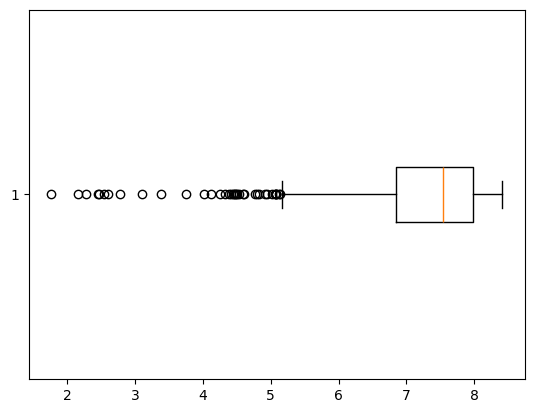

In [36]:
rewards_mod = rewards - np.mean(rewards)
rewards_mod = rewards_mod / np.std(rewards)
rewards_mod = rewards_mod - ( np.min(rewards) )

plt.boxplot(transform_rewards(rewards), vert=False)
plt.show()

To understand the basics, let's first create a random agent that takes random actions.

In [65]:
done = False
obs, info = env.reset()
frames = []

while not done:
    action = env.action_space.sample()  # Take a random action
    obs, reward, done, truncated, info = env.step(action)
    print(f"State: {obs['image'][:, :, 0]}, Action: {action}, Reward: {reward}, Done: {done}")
    
    # Store frames for visualization
    frames.append(env.render())

State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 1 1 1]
 [2 2 2 2 1 1 1]
 [2 2 2 2 8 1 1]
 [2 2 2 2 2 2 2]], Action: 5, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 1 1 1]
 [2 2 2 2 1 1 1]
 [2 2 2 2 8 1 1]
 [2 2 2 2 2 2 2]], Action: 6, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 2]], Action: 0, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 1 1 1]
 [2 2 2 2 1 1 1]
 [2 2 2 2 8 1 1]
 [2 2 2 2 2 2 2]], Action: 1, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 2]], Action: 0, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]], Action: 0, Reward: 0, Done: False
State: [[2 2 2 2 2 2 2]
 [2 

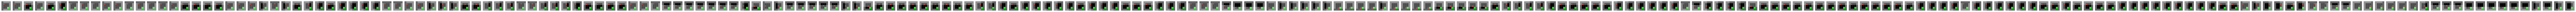

In [66]:
# Show the final path
fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 5))
for i, frame in enumerate(frames):
    axes[i].imshow(frame)
    axes[i].axis("off")
plt.show()

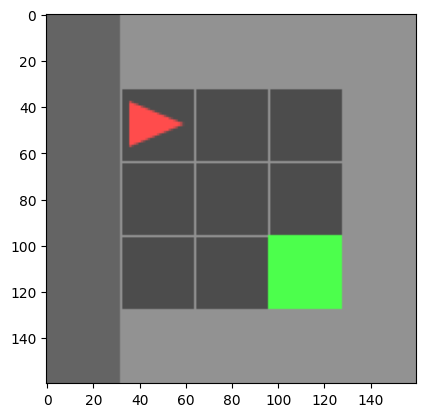

In [67]:
# Here, we attempt to visualise the frames as an animation

fig, ax = plt.subplots()
im = ax.imshow(frames[0])

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=frames, interval=300)

HTML(ani.to_jshtml())

### Now train an RL agent using `stable-baseline3`


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 78.1     |
|    ep_rew_mean     | 0.249    |
| time/              |          |
|    fps             | 302      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 79.9        |
|    ep_rew_mean          | 0.234       |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008039007 |
|    clip_fraction        | 0.0855      |
|    clip_range     

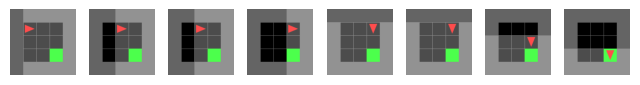

In [10]:
from stable_baselines3 import PPO

# Wrap environment for image-based input
env = ImgObsWrapper(RGBImgPartialObsWrapper(gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")))

# Initialize and train the agent
model = PPO("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)

# Test trained agent
obs, info = env.reset()
done = False
frames = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    frames.append(env.render())

# Show the trained agent's path
fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 5))
for i, frame in enumerate(frames):
    axes[i].imshow(frame)
    axes[i].axis("off")
plt.show()


### Train an agent using the Monte Carlo Method

In [4]:
# This ensures the reward function is always positive
def transform_rewards(rewards):
    rewards_mod = rewards - (-0.47195000000000004)
    rewards_mod = rewards_mod / (1.2342575685406998)
    rewards_mod = rewards_mod - ( -7.2620000000000005 )

    return abs(rewards_mod)

In [26]:
import base64

class MonteCarloModel:
    ActionValueFunction = {} # This will map states onto actions onto rewards

    def __init__(self, env, num_episodes=1000, verbose=1):
        self.env = env
        self.num_episodes = num_episodes # This is the number of times the agent will run
        self.alpha = 0.1 # Learning rate
        self.verbose = verbose

    def CreateDefaultDict(self):

        default_dictionary = {} # Add random values to the actions

        for i in range(self.env.action_space.n): 
            default_dictionary[i] = 0 # Instead of randomisation, set to 0 value

        return default_dictionary
    
    # Function to serialize (encode) a NumPy array to a string
    def numpy_to_string(self, array):
        array_bytes = array.tobytes()
        array_shape = array.shape
        array_dtype = array.dtype
        metadata = f"{array_shape}|{array_dtype}"
        encoded_bytes = base64.b64encode(array_bytes).decode('utf-8')
        return f"{metadata}|{encoded_bytes}"
    # The serialization process ensures that distinct NumPy arrays produce 
    # distinct serialized strings. Hence, it is injective and one-to-one.

    # Function to deserialize (decode) a NumPy array from a string
    def string_to_numpy(self, serialized_string):
        metadata, encoded_bytes = serialized_string.rsplit('|', 1)
        array_shape, array_dtype = metadata.split('|')
        array_shape = tuple(map(int, array_shape.strip('()').split(',')))
        array_dtype = np.dtype(array_dtype)
        array_bytes = base64.b64decode(encoded_bytes)
        return np.frombuffer(array_bytes, dtype=array_dtype).reshape(array_shape)
    

    def diffuse_rewards(self, rewards):
        max_exponent = len(rewards) - 1
        exp_values = [math.exp(i - max_exponent) for i in range(len(rewards))]
        total = sum(exp_values)
        a = rewards[-1] / total
        return [a * exp_val for exp_val in exp_values]


    def learn(self):
        for episode in range(self.num_episodes):
            obs, info = self.env.reset()
            done = False
            reward = 0

            states = []
            actions = []
            rewards = []

            while not done:
                if random.random() > 0.5:
                    action = self.env.action_space.sample() # This allows off-policy learning to take place
                else:
                    action, _ = self.predict(obs) # This allows on-policy learning to take place
                obs, reward, done, truncated, info = self.env.step(action)
                # Store the state-action pair and the reward
                reward = transform_rewards(reward) # This is a tranformation to ensure that reward is always positive
                states.append(self.numpy_to_string(obs['image'][:, :, 0]))
                actions.append(action) 
                rewards.append(reward)
                print(f"\r Currently on step {len(states) - 1} ", end="")

            rewards = self.diffuse_rewards(rewards)

            for i in range(len(states)):
                if states[i] not in self.ActionValueFunction.keys():
                    self.ActionValueFunction[states[i]] = self.CreateDefaultDict()

                self.ActionValueFunction[states[i]][actions[i]] = self.ActionValueFunction[states[i]][actions[i]] + self.alpha * ( rewards[i] - self.ActionValueFunction[states[i]][actions[i]] )

            if self.verbose == 1:
                print(f"\r Game {episode} of length {len(states)} steps completed and value function updated.")

    def predict(self, obs):
        try:
            obs = self.numpy_to_string(obs['image'][:, :, 0])
            actions = self.ActionValueFunction[obs]

            return max(actions, key=actions.get), None

        except Exception as error:
            print("An exception occurred:", error)

            return self.env.action_space.sample(), None

In [27]:
model = MonteCarloModel(env, num_episodes=100)
model.learn()

# Test trained agent
print("\n Testing the agent now ...")
obs, info = env.reset()
done = False
frames = []

step_counter = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    frames.append(env.render())

    step_counter += 1
    if step_counter % 2 == 0:
        print(f"\r The game is on step {step_counter} with {action} action taken.", end="", flush=True)

    # plt.imshow(frames[-1])
    # plt.show()

# Show the trained agent's path
print("Rendering the outcome ...")
fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 5))
for i, frame in enumerate(frames):
    axes[i].imshow(frame)
    axes[i].axis("off")
plt.show()

"""
There is a lot of room for improvement in the Monte Carlo model.
The problem is in the learning process, where the rewards are not approportately capturing the 
nature of the problem.

The reward function is not well defined, and the agent does not learn to take the right actions.
The reward function should give rewards at each step. However, this solution needs to be compared
with existing work in the field of reinforcement learning to understand the paradigm of how reward 
functions are defined.
"""

 Currently on step 2 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgIIAQECAgICAQEBAgICAgEBAQICAgICAgICAgICAgICAgICAgICAg=='
 Currently on step 7 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgICAgICAgICAgICAgICAgEBAQICAgIBAQECAgICCAEBAgICAgICAg=='
 Currently on step 8 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgICAgICAgICAgICAgICAgEBAQICAgIBAQECAgICCAEBAgICAgICAg=='
 Currently on step 10 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgIIAQECAgICAQEBAgICAgEBAQICAgICAgICAgICAgICAgICAgICAg=='
 Currently on step 13 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgICAgICAgICAgICAgICAgEBAQICAgIBAQECAgICCAEBAgICAgICAg=='
 Currently on step 14 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgICAgICAgICAgICAgICAgICAQICAgICAgECAgICAgIBAgICAgICAg=='
 Currently on step 18 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgICAgECAgICAgIBAgICAgICAQICAgICAgICAgICAgICAgICAgICAg=='
 Currently on step 19 An exception occurred: '(7, 7)|uint8|AgICAgICAgICAgICAgECAgICAgIBAgICAgICAQICA

KeyboardInterrupt: 

In [24]:
model.ActionValueFunction

{'(7, 7)|uint8|AgICAgICAgICAgICAgICAgICAgICAgICAgICAQICAgICAgECAgICAgIBAgICAgICAg==': {0: 3.40634746412365e-08,
  1: 1.3696838507308565e-06,
  2: 1.3242749780112653,
  3: 3.5732615076657863e-10,
  4: 3.832698842992826e-09,
  5: 6.008407149257763e-10,
  6: 7.039341766141261e-09},
 '(7, 7)|uint8|AgICAgICAgICAgICAgECAgICAgIBAgICAgICAQICAgICAgICAgICAgICAgICAgICAg==': {0: 2.0143507069591363e-08,
  1: 3.7060462591268736e-06,
  2: 0.22089407162860655,
  3: 1.8225694417728681e-06,
  4: 2.2301370895859976e-05,
  5: 5.719574538987895e-06,
  6: 1.8529074146603848e-07},
 '(7, 7)|uint8|AgICAgICAgICAgIIAQECAgICAQEBAgICAgEBAQICAgICAgICAgICAgICAgICAgICAg==': {0: 6.20005132818514e-08,
  1: 5.737383607986311e-06,
  2: 0,
  3: 7.410623432623135e-09,
  4: 2.182159884151846e-08,
  5: 2.7369263794369878e-09,
  6: 1.887340811979045e-12},
 '(7, 7)|uint8|AgICAgICAgICAgICCAECAgICAgEBAgICAgIBAQICAgICAgICAgICAgICAgICAgICAg==': {0: 4.126462447405624e-05,
  1: 2.0342415113337716e-05,
  2: 5.141367696576348e-08,
  3